# Setting up the working env

In [ ]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install matplotlib pillow

In [ ]:
# Install dependencies if we are running in colab
if 'google.colab' in sys.modules:
    %pip install botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from botorch.test_functions.multi_objective import BraninCurrin
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.sampling import sample_simplex


from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)



In [ ]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TFG/

/content/drive/MyDrive/TFG


# Creating the Problem statement and initialization

## Loading ADNIMERGE data

In [ ]:
# TODO: PROBAR PROBLEMA BINARIO ASI EMCI LMCI

# TODO CAMBIAR DX POR DX_bl

pd.set_option('display.max_columns', None)
adnimerge = pd.read_parquet('./reduced_baseline_adnimerge_df.parquet')
adnimerge.head()


,DX_bl,RID,ADAS13
0,CN,2,18.67
1,AD,3,31.00
5,LMCI,4,21.33
10,CN,5,14.67
15,LMCI,6,25.67


In [ ]:
adnimerge.isna().sum()

,0
DX_bl,12
RID,0
ADAS13,25


In [ ]:
adnimerge.dropna(inplace=True)

In [ ]:
adnimerge.shape

(2396, 3)

In [ ]:
adnimerge.dtypes

,0
DX_bl,object
RID,int64
ADAS13,float64


In [ ]:
adnimerge['DX_bl'] = adnimerge['DX_bl'].astype('string')

In [ ]:
adnimerge['DX_bl'].unique()

<StringArray>
['CN', 'AD', 'LMCI', 'SMC', 'EMCI']
Length: 5, dtype: string

### Creating the subset to be used (binary vs multiclass)

In [ ]:
adnimerge_sub = adnimerge[adnimerge['DX_bl'].isin(['LMCI', 'EMCI'])]
adnimerge_sub = adnimerge_sub[['RID', 'DX_bl']]
adnimerge_sub.head()

,RID,DX_bl
5,4,LMCI
15,6,LMCI
61,38,LMCI
69,42,LMCI
84,45,LMCI


In [ ]:
adnimerge_sub.shape

(1103, 2)

In [ ]:
import pandas as pd
roi_aparc = pd.read_parquet('./baseline_roi_aparc_df.parquet')
roi_aparc['RID'] = roi_aparc['RID'].astype(int)
roi_aparc.drop(columns=['subject', 'session_number'], inplace=True)
(roi_aparc.head())
data = adnimerge_sub.merge(roi_aparc, on='RID', how='inner')
data.shape


(1074, 154)

In [ ]:
data.columns

Index(['RID', 'DX_bl', 'lUnknown', 'rUnknown', 'lG_and_S_frontomargin',
       'rG_and_S_frontomargin', 'lG_and_S_occipital_inf',
       'rG_and_S_occipital_inf', 'lG_and_S_paracentral',
       'rG_and_S_paracentral',
       ...
       'lS_suborbital', 'rS_suborbital', 'lS_subparietal', 'rS_subparietal',
       'lS_temporal_inf', 'rS_temporal_inf', 'lS_temporal_sup',
       'rS_temporal_sup', 'lS_temporal_transverse', 'rS_temporal_transverse'],
      dtype='object', length=154)

In [ ]:
data.head(5)

,RID,DX_bl,lUnknown,rUnknown,lG_and_S_frontomargin,rG_and_S_frontomargin,lG_and_S_occipital_inf,rG_and_S_occipital_inf,lG_and_S_paracentral,rG_and_S_paracentral,lG_and_S_subcentral,rG_and_S_subcentral,lG_and_S_transv_frontopol,rG_and_S_transv_frontopol,lG_and_S_cingul-Ant,rG_and_S_cingul-Ant,lG_and_S_cingul-Mid-Ant,rG_and_S_cingul-Mid-Ant,lG_and_S_cingul-Mid-Post,rG_and_S_cingul-Mid-Post,lG_cingul-Post-dorsal,rG_cingul-Post-dorsal,lG_cingul-Post-ventral,rG_cingul-Post-ventral,lG_cuneus,rG_cuneus,lG_front_inf-Opercular,rG_front_inf-Opercular,lG_front_inf-Orbital,rG_front_inf-Orbital,lG_front_inf-Triangul,rG_front_inf-Triangul,lG_front_middle,rG_front_middle,lG_front_sup,rG_front_sup,lG_Ins_lg_and_S_cent_ins,rG_Ins_lg_and_S_cent_ins,lG_insular_short,rG_insular_short,lG_occipital_middle,rG_occipital_middle,lG_occipital_sup,rG_occipital_sup,lG_oc-temp_lat-fusifor,rG_oc-temp_lat-fusifor,lG_oc-temp_med-Lingual,rG_oc-temp_med-Lingual,lG_oc-temp_med-Parahip,rG_oc-temp_med-Parahip,lG_orbital,rG_orbital,lG_pariet_inf-Angular,rG_pariet_inf-Angular,lG_pariet_inf-Supramar,rG_pariet_inf-Supramar,lG_parietal_sup,rG_parietal_sup,lG_postcentral,rG_postcentral,lG_precentral,rG_precentral,lG_precuneus,rG_precuneus,lG_rectus,rG_rectus,lG_subcallosal,rG_subcallosal,lG_temp_sup-G_T_transv,rG_temp_sup-G_T_transv,lG_temp_sup-Lateral,rG_temp_sup-Lateral,lG_temp_sup-Plan_polar,rG_temp_sup-Plan_polar,lG_temp_sup-Plan_tempo,rG_temp_sup-Plan_tempo,lG_temporal_inf,rG_temporal_inf,lG_temporal_middle,rG_temporal_middle,lLat_Fis-ant-Horizont,rLat_Fis-ant-Horizont,lLat_Fis-ant-Vertical,rLat_Fis-ant-Vertical,lLat_Fis-post,rLat_Fis-post,lMedial_wall,rMedial_wall,lPole_occipital,rPole_occipital,lPole_temporal,rPole_temporal,lS_calcarine,rS_calcarine,lS_central,rS_central,lS_cingul-Marginalis,rS_cingul-Marginalis,lS_circular_insula_ant,rS_circular_insula_ant,lS_circular_insula_inf,rS_circular_insula_inf,lS_circular_insula_sup,rS_circular_insula_sup,lS_collat_transv_ant,rS_collat_transv_ant,lS_collat_transv_post,rS_collat_transv_post,lS_front_inf,rS_front_inf,lS_front_middle,rS_front_middle,lS_front_sup,rS_front_sup,lS_interm_prim-Jensen,rS_interm_prim-Jensen,lS_intrapariet_and_P_trans,rS_intrapariet_and_P_trans,lS_oc_middle_and_Lunatus,rS_oc_middle_and_Lunatus,lS_oc_sup_and_transversal,rS_oc_sup_and_transversal,lS_occipital_ant,rS_occipital_ant,lS_oc-temp_lat,rS_oc-temp_lat,lS_oc-temp_med_and_Lingual,rS_oc-temp_med_and_Lingual,lS_orbital_lateral,rS_orbital_lateral,lS_orbital_med-olfact,rS_orbital_med-olfact,lS_orbital-H_Shaped,rS_orbital-H_Shaped,lS_parieto_occipital,rS_parieto_occipital,lS_pericallosal,rS_pericallosal,lS_postcentral,rS_postcentral,lS_precentral-inf-part,rS_precentral-inf-part,lS_precentral-sup-part,rS_precentral-sup-part,lS_suborbital,rS_suborbital,lS_subparietal,rS_subparietal,lS_temporal_inf,rS_temporal_inf,lS_temporal_sup,rS_temporal_sup,lS_temporal_transverse,rS_temporal_transverse
0,4,LMCI,1.986359,1.926012,2.235178,2.199780,2.263434,2.586857,2.051794,1.902948,2.314763,2.445275,2.276910,2.352085,2.504892,2.352772,2.428664,2.321035,2.397175,2.225512,2.591127,2.649444,2.377577,2.628912,1.745167,1.629821,2.553475,2.503641,2.588122,2.493712,2.239265,2.354536,2.330980,2.391344,2.521309,2.431288,3.281339,3.034438,3.676079,3.898588,2.257806,2.326474,2.082201,1.964689,2.331578,2.490000,1.842906,1.933253,2.921091,3.126393,2.695209,2.805978,2.422602,2.501791,2.411938,2.372590,2.196704,2.141227,1.978632,2.078509,1.924300,2.039493,2.372580,2.374773,2.291711,2.495232,2.543986,3.220273,1.908910,2.289189,2.722966,2.812194,3.404710,3.642868,2.352714,2.375830,2.681285,2.757351,2.710977,2.849796,2.299123,2.367012,2.341449,2.343801,1.968207,2.403490,NaN,NaN,1.831361,1.925835,3.106892,3.173338,1.787686,2.043565,1.595498,1.661827,2.404563,2.308197,3.458154,3.415487,3.000959,3.066050,2.725759,2.919006,2.802477,2.654570,1.822014,1.979481,2.138143,2.206768,2.186763,2.219792,2.522033,2.359838,2.301323,2.402576,2.041849,2.140886,2.015811,1.957807,2.070450,1.968242,2.

In [ ]:
data.shape

(1074, 154)

In [ ]:
pd.set_option('display.max_rows',None)

y_classification = data['DX_bl']
X = data.drop(columns=['RID', 'DX_bl'])

X.isna().sum()

,0
lUnknown,0
rUnknown,0
lG_and_S_frontomargin,0
rG_and_S_frontomargin,0
lG_and_S_occipital_inf,0
rG_and_S_occipital_inf,0
lG_and_S_paracentral,0
rG_and_S_paracentral,0
lG_and_S_subcentral,0
rG_and_S_subcentral,0


In [ ]:
X.drop(columns= ['lMedial_wall', 'rMedial_wall'], inplace=True)

### Analyze data

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


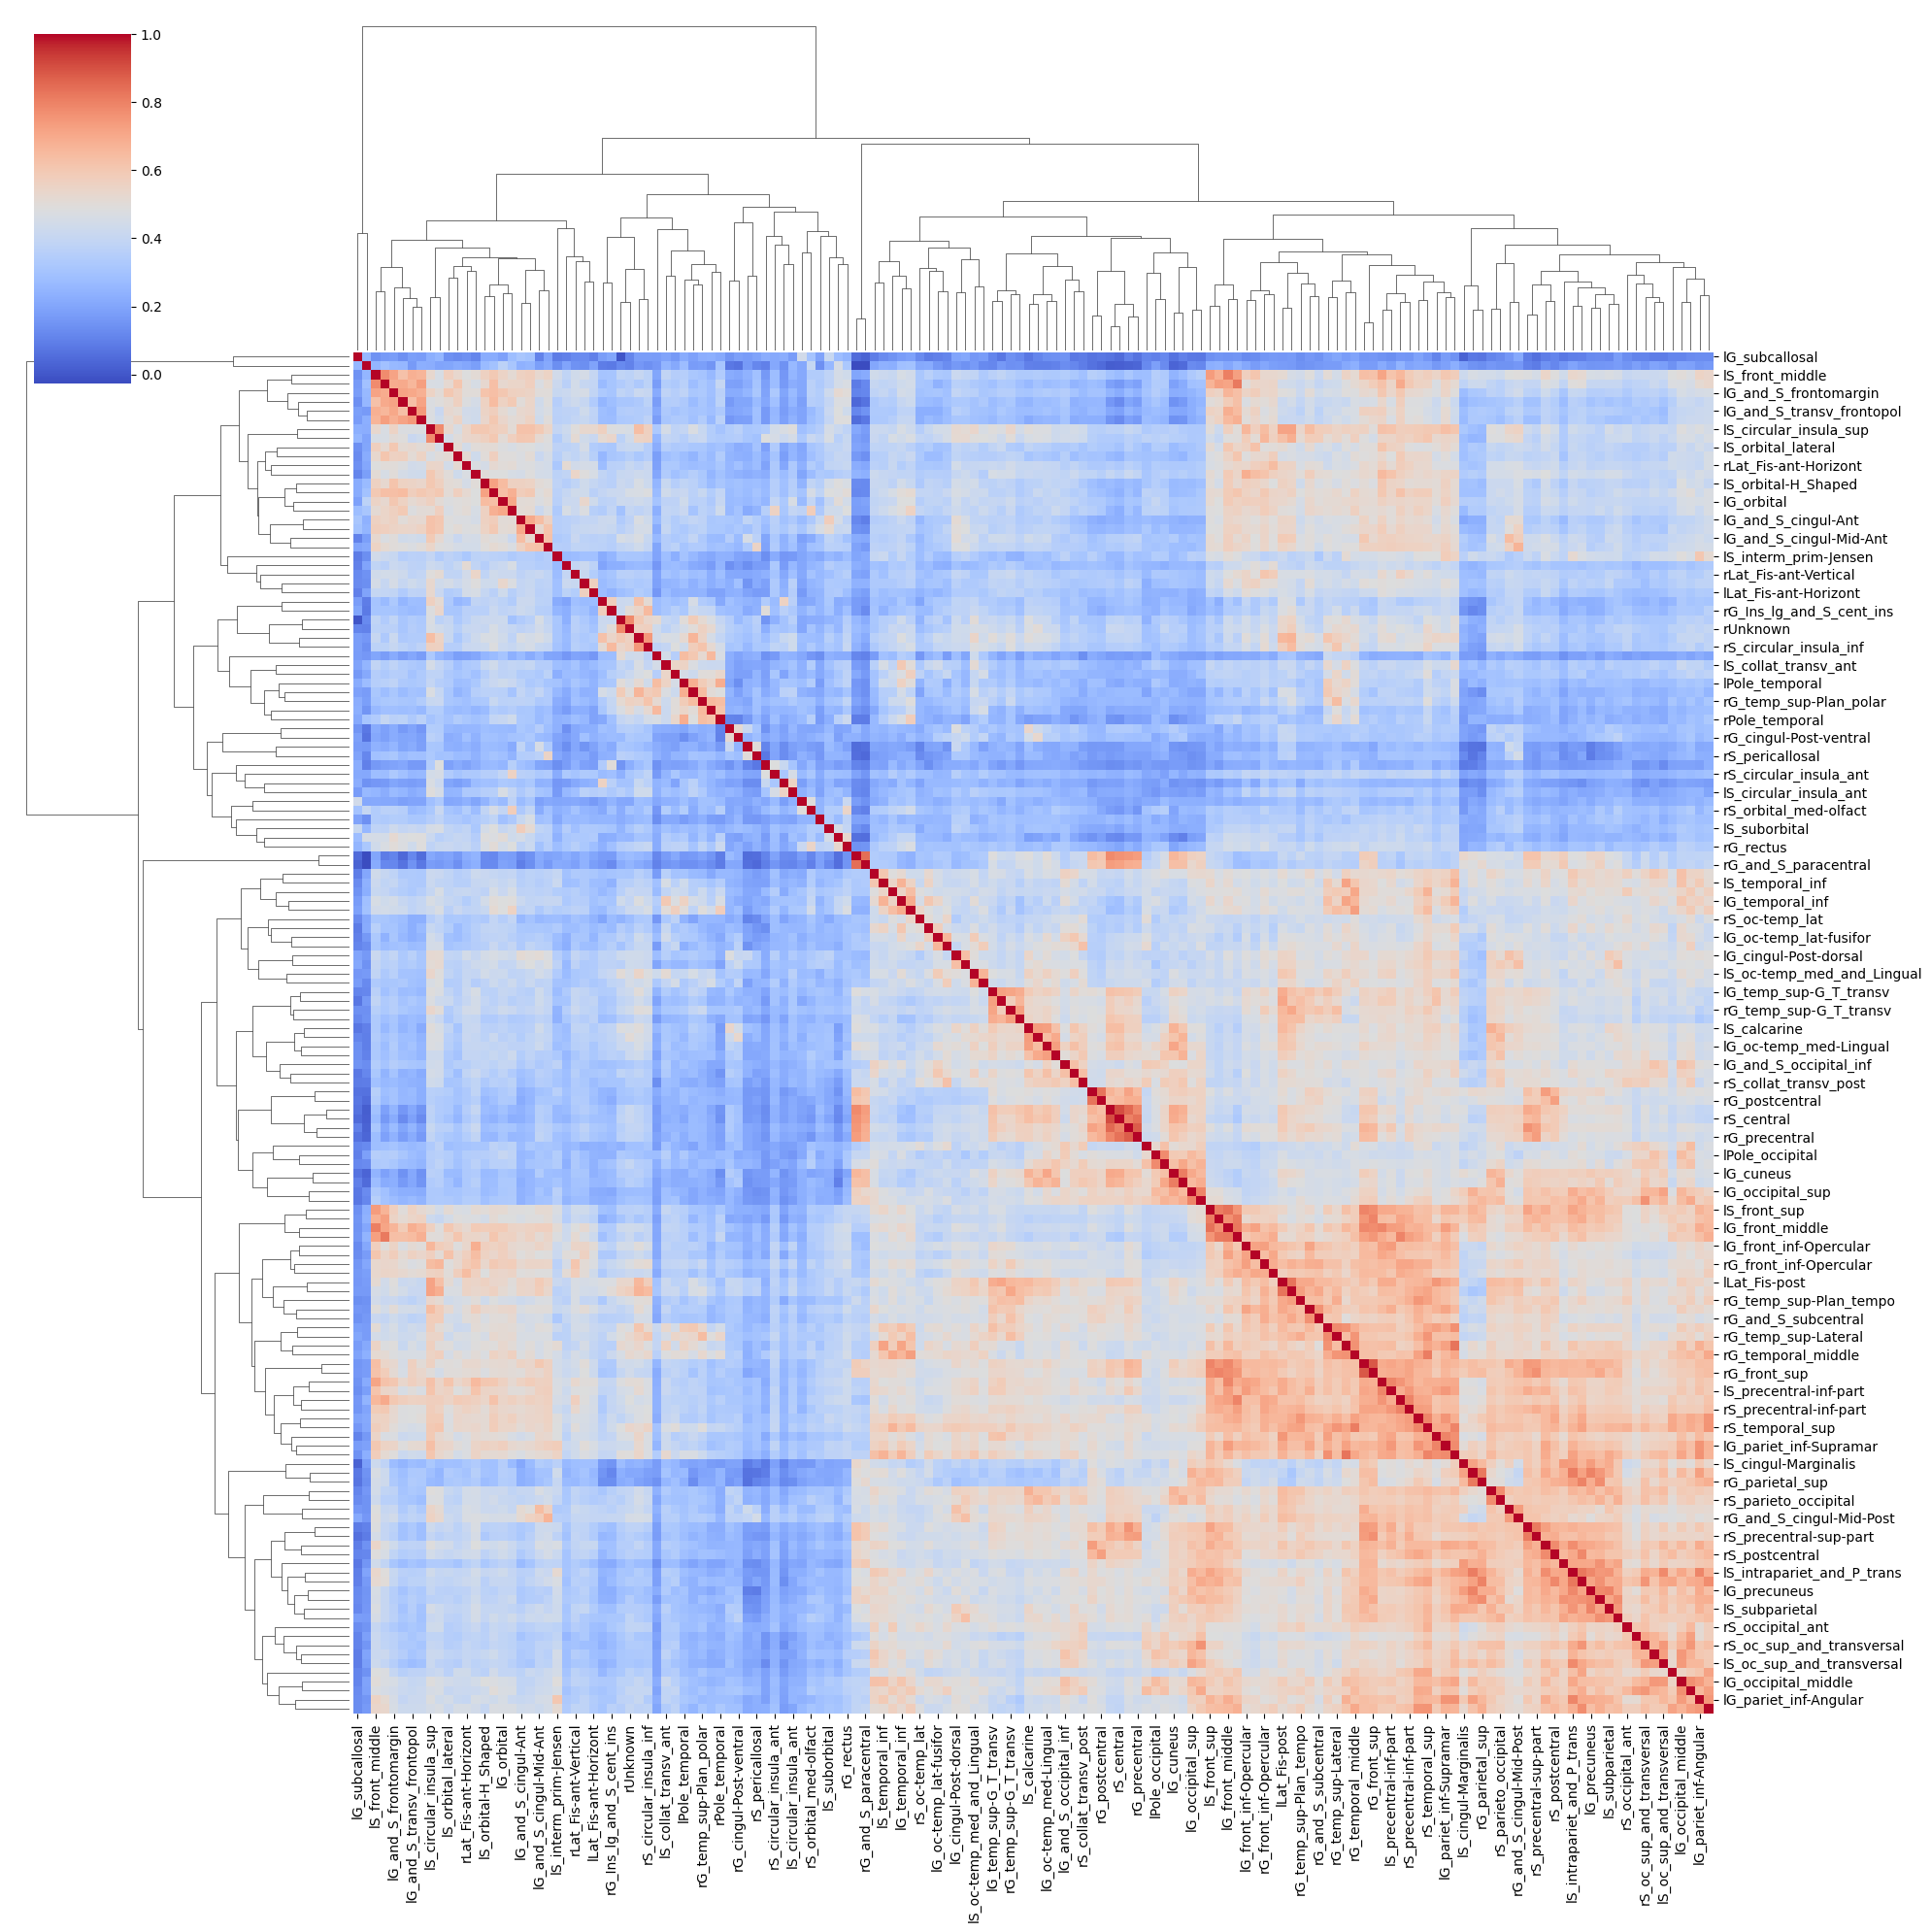

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
threshold = 0.7
filtered_corr = corr[((corr >= threshold) | (corr <= -threshold)) & (corr != 1.0)]

sns.clustermap(corr, cmap="coolwarm", figsize=(20, 20))

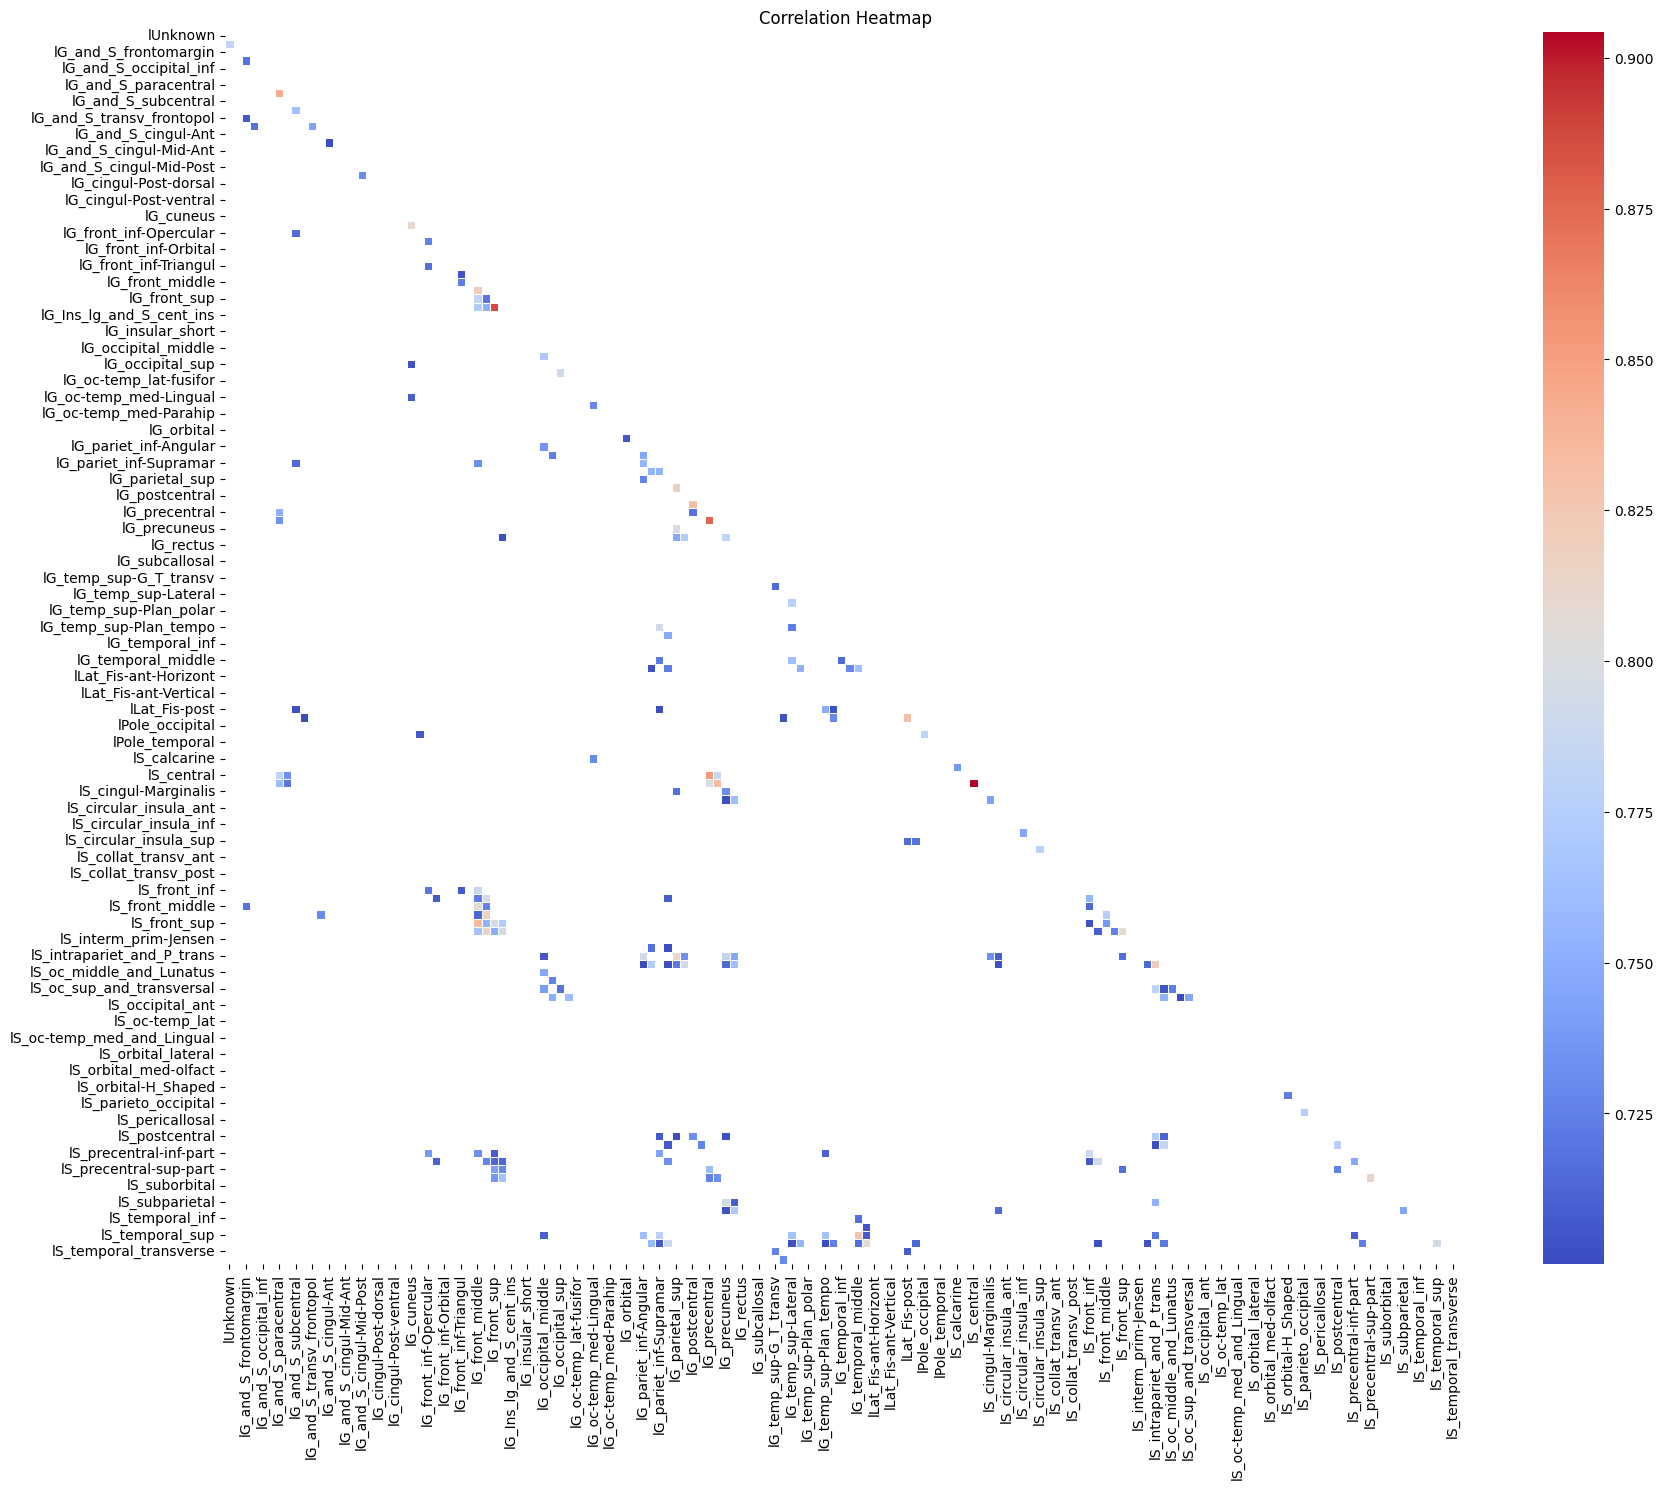

In [ ]:
plt.figure(figsize=(20, 16))  # adjust size depending on how many columns
sns.heatmap(filtered_corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Create train and test sets

In [ ]:
#from cuml.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

X = X.astype('float32')
y_clas_enc = LabelEncoder()
y_classification = y_clas_enc.fit_transform(y_classification)

In [ ]:
#from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)


## Problem (RF)

### Estimate a RF to have a general idea of performance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Val acc is {accuracy}')

Val acc is 0.6465116279069767


### RF Optimization Problem

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


# Define the optimization problem
class RFOptimizationProblem:
    def __init__(self, bounds, X_train, X_val, y_train, y_val):
        self.bounds = bounds  # Define search space
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.dim = bounds.shape[1]
        self.num_objectives = 2

        #TODO: check if this is correct with tutors!!!!

        max_depth_bound = self.bounds[1,1]

        self.ref_point = torch.tensor([0, -1 * max_depth_bound + 10]).to(**tkwargs)  # Reference point for hypervolume, assume that it is the lower bound of the objective functions


    def evaluate_rf(self, x):
        """
        Trains an RF model for a row x and returns accuracy and tree depth.
        x: Tensor containing a set of hyperparameters, shape (1, 4)

        Returns:
            - Accuracy (to maximize)
            - Depth (to minimize)
        """

        #TODO: Son discretos...???
        n_estimators = int(x[0].item())
        max_depth = int(x[1].item()) if x[1].item() > 0 else None
        min_samples_split = int(x[2].item())
        min_samples_leaf = int(x[3].item())

        # Train Random Forest
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(self.X_train, self.y_train)

        # Predict and evaluate
        y_pred = model.predict(self.X_val)
        accuracy = accuracy_score(self.y_val, y_pred)

        # Estimate average tree depth
        #actual_depth = np.mean([tree.tree_.max_depth for tree in model.estimators_])

        results = [accuracy, max_depth]

        return torch.tensor(results, **tkwargs)  # Return tensor with shape (batch_size, 2)


    def evaluate(self, x):
        """
        Given input hyperparameters `x`, evaluate the RF model.
        Returns [accuracy, depth] (accuracy to be maximized, depth to be minimized).
        """
        noise = x[-2:]
        # x = x[:-2]
        results = self.evaluate_rf(x)  # Assume this function is defined elsewhere
        results[1] *= -1
        return results # Negate depth for minimization



bounds = torch.tensor([
    [10.0, 2.0, 2.0, 1.0],   # Lower bounds: n_estimators, max_depth, min_samples_split, min_samples_leaf
    [200.0, 100.0, 10.0, 10.0] # Upper bounds
], **tkwargs)  # Shape (4,2) for Botorch

# Instantiate problem
problem = RFOptimizationProblem(bounds, X_train, X_val, y_train, y_val)'''

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\nimport numpy as np\n\n\n# Define the optimization problem\nclass RFOptimizationProblem:\n    def __init__(self, bounds, X_train, X_val, y_train, y_val):\n        self.bounds = bounds  # Define search space\n        self.X_train = X_train\n        self.y_train = y_train\n        self.X_val = X_val\n        self.y_val = y_val\n        self.dim = bounds.shape[1]\n        self.num_objectives = 2\n\n        #TODO: check if this is correct with tutors!!!!\n\n        max_depth_bound = self.bounds[1,1]\n\n        self.ref_point = torch.tensor([0, -1 * max_depth_bound + 10]).to(**tkwargs)  # Reference point for hypervolume, assume that it is the lower bound of the objective functions\n\n\n    def evaluate_rf(self, x):\n        """\n        Trains an RF model for a row x and returns accuracy and tree depth.\n        x: Tensor containing a set of hyperparameters, shape (1, 4)\n\n        Returns:\n   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

import numpy as np

# VERSION WITH STATIFIED K FOLD CV and

# Define the optimization problem
class RFOptimizationProblem:
    def __init__(self, bounds, X_train, X_test, y_train, y_test):
        self.bounds = bounds  # Define search space
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.dim = bounds.shape[1]
        self.num_objectives = bounds.shape[0] #2 for us always

        max_depth_bound = self.bounds[1,1]

        self.ref_point = torch.tensor([0, -1 * max_depth_bound + 2]).to(**tkwargs)  # Reference point for hypervolume, assume that it is the lower bound of the objective functions


    def evaluate_rf(self, x):
        """
        Trains an RF model for a row x and returns accuracy and tree depth.
        x: Tensor containing a set of hyperparameters, shape (1, 4)

        Returns:
            - Accuracy (to maximize)
            - Depth (to minimize)
        """

        n_estimators = int(x[0].item())
        max_depth = int(x[1].item()) if x[1].item() > 0 else None
        min_samples_split = int(x[2].item())
        min_samples_leaf = int(x[3].item())

        # Train Random Forest
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        #model.fit(self.X_train, self.y_train)
        # If we do cv we dont want to fit, we need to fit with the cross val score
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform cross-validation with the defined splitter
        cv_acc = cross_val_score(model, self.X_train, self.y_train, cv=cv, scoring='accuracy')

        accuracy = np.mean(cv_acc)
        # TODO: We could add a acc that is mean - std to express the std too

        results = [accuracy, max_depth]

        return torch.tensor(results, **tkwargs)  # Return tensor with shape (batch_size, 2)


    def evaluate(self, x):
        """
        Given input hyperparameters `x`, evaluate the RF model.
        Returns [accuracy, depth] (accuracy to be maximized, depth to be minimized).
        """
        results = self.evaluate_rf(x)  # Assume this function is defined elsewhere
        results[1] *= -1
        return results # Negate depth for minimization



bounds = torch.tensor([
    [10.0, 2.0, 2.0, 1.0],   # Lower bounds: n_estimators, max_depth, min_samples_split, min_samples_leaf
    [200.0, 100.0, 10.0, 10.0] # Upper bounds
], **tkwargs)  # Shape (4,2) for Botorch

# Instantiate problem
problem = RFOptimizationProblem(bounds, X_train, X_test, y_train, y_test)

In [ ]:
data = draw_sobol_samples(bounds=problem.bounds, n=6, q=1).squeeze(1)
print(data)
for x in data:
  print(problem.evaluate(x))


tensor([[110.9898,  47.2248,   4.8475,   6.4311],
        [ 10.5259,  74.8534,   9.7224,   2.8270],
        [ 93.1102,   3.6730,   3.5103,   8.3964],
        [181.7164,  80.1686,   6.8855,   5.3571],
        [172.9235,  24.5289,   8.4553,   4.3587],
        [ 71.7059,  94.9115,   5.0802,   9.6492]], device='cuda:0',
       dtype=torch.float64)
tensor([  0.7218, -47.0000], device='cuda:0', dtype=torch.float64)
tensor([  0.6845, -74.0000], device='cuda:0', dtype=torch.float64)
tensor([ 0.7171, -3.0000], device='cuda:0', dtype=torch.float64)
tensor([  0.7311, -80.0000], device='cuda:0', dtype=torch.float64)
tensor([  0.7241, -24.0000], device='cuda:0', dtype=torch.float64)
tensor([  0.7334, -94.0000], device='cuda:0', dtype=torch.float64)


## Init

In [ ]:
def generate_initial_data(n=6):
    # Generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)

    #Evaluate the objective function
    train_obj_true = torch.stack([problem.evaluate(x) for x in train_x])

    # TODO: check con profe que esto esta bien aunque creo que sí: Add noise to simulate real-world variation
    #train_obj = train_obj_true + torch.randn_like(train_obj_true)

    return train_x, train_obj_true


In [ ]:
generate_initial_data(n=6)

(tensor([[ 42.6486,  21.6221,   3.8613,   2.5643],
         [118.9997,  87.0120,   8.5180,   7.9415],
         [159.9017,  44.2482,   5.0886,   4.9077],
         [ 93.7528,  52.1713,   6.3059,   5.7167],
         [ 66.6739,  32.8047,   9.2452,   7.3351],
         [192.2007,  74.4168,   2.3990,   4.2780]], device='cuda:0',
        dtype=torch.float64),
 tensor([[  0.7194, -21.0000],
         [  0.7287, -87.0000],
         [  0.7264, -44.0000],
         [  0.7381, -52.0000],
         [  0.7334, -32.0000],
         [  0.7264, -74.0000]], device='cuda:0', dtype=torch.float64))

In [ ]:
from botorch.models.multitask import MultiTaskGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood


def initialize_model(train_x, train_obj):
    train_x = normalize(train_x, problem.bounds)

    # Suponiendo que train_obj tiene forma (N, M) donde M es el número de objetivos
    num_tasks = train_obj.shape[-1]  # Número de objetivos
    # train_yvar = torch.full_like(train_obj, NOISE_SE ** 2)  # Varianza del ruido

    # MultiTaskGP espera que el input `train_y` tenga la forma (N, M)
    model = MultiTaskGP(train_x, train_obj, num_tasks=num_tasks, outcome_transform=Standardize(m=num_tasks))

    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model


# Opti QEHVI

From tutorial:

qEHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

In [ ]:
SMOKE_TEST = False
BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

In [ ]:
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement

def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles

    normalized_bounds = torch.stack([
                torch.zeros_like(problem.bounds[0]),
                torch.ones_like(problem.bounds[1]),
                ])

    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=problem.ref_point,
        Y=pred,
    )
    acq_func = qLogExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = torch.stack([problem.evaluate(x) for x in new_x])
    #new_noise = new_x[:, -2:]

    #new_obj = new_obj_true + torch.randn_like(new_obj_true) * new_noise
    return new_x, new_obj_true

# Opti QNEHVI

In [ ]:
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement


def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    normalized_bounds = torch.stack([
                torch.zeros_like(problem.bounds[0]),
                torch.ones_like(problem.bounds[1]),
                ])

    acq_func = qLogNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = torch.stack([problem.evaluate(x) for x in new_x])
    #new_noise = new_x[:, -2:]

    #new_obj = new_obj_true + torch.randn_like(new_obj_true) * new_noise
    return new_x, new_obj_true

# Opti QNParego

In [ ]:
from botorch.acquisition.logei import qLogNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qNParEGO acquisition function, and returns a new candidate and observation."""

    normalized_bounds = torch.stack([
                torch.zeros_like(problem.bounds[0]),
                torch.ones_like(problem.bounds[1]),
                ])

    train_x = normalize(train_x, problem.bounds)

    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(
            get_chebyshev_scalarization(weights=weights, Y=pred)
        )
        acq_func = qLogNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=normalized_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values

    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = torch.stack([problem.evaluate(x) for x in new_x])
    #new_noise = new_x[:, -2:]

    #new_obj = new_obj_true + torch.randn_like(new_obj_true) * new_noise
    return new_x, new_obj_true

# Optimization loop

In [ ]:
import time
import warnings
import torch

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
import matplotlib.pyplot as plt
from IPython.display import clear_output


N_BATCH = 50 if not SMOKE_TEST else 5
MC_SAMPLES = 128 if not SMOKE_TEST else 16
verbose = True

# def should_continue(hvs_list, current_volume, tol_window=3, tolerance = 0.0001):
#     tol_window += 1
#     if len(hvs_list) < tol_window:
#         return True
#     prev_mean = sum(hvs_list[-tol_window:-1]) / tol_window
#     return abs(current_volume - prev_mean) < tolerance

def check_hv_early_stopping(hvs_list, threshold=1e-4, patience=5):
    """
    Early stopping if HV has not improved more than `threshold`
    for `patience` consecutive iterations.

    Parameters:
    - hvs_list: list of HV values per iteration
    - threshold: min improvement to be considered "progress"
    - patience: number of allowed consecutive stagnant iterations
    """
    if len(hvs_list) < patience:
        return True

    # Count how many iterations since last significant improvement
    stagnant_iters = 0
    for i in range(len(hvs_list) - 1, 0, -1):
        delta = hvs_list[i] - hvs_list[i - 1]
        if delta < threshold:
            stagnant_iters += 1
        else:
            break  # reset count on any significant improvement

        if stagnant_iters >= patience:
            return False

    return True


def plot_hv_progress(hv_dict):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    for label, values in hv_dict.items():
        plt.plot(values, label=label)

    plt.xlabel("Iteration")
    plt.ylabel("Hypervolume")
    plt.title("Hypervolume Progress")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



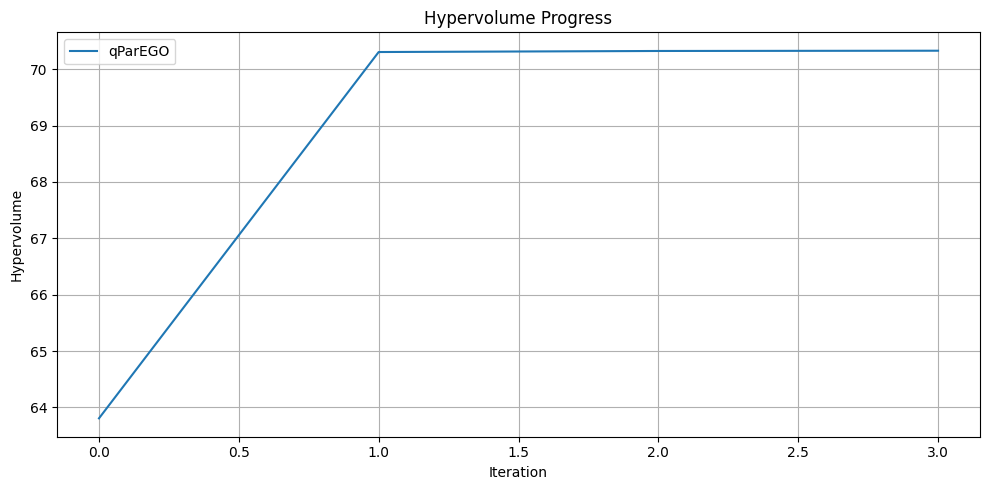

[qParEGO] Batch 3: HV = 70.3262, time = 21.07s


In [ ]:
hvs_qparego = []
train_x_qparego, train_obj_true_qparego = generate_initial_data(n=2 * (problem.dim + 1))
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_true_qparego)

bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()
hvs_qparego.append(volume)

iteration = 0
while iteration < N_BATCH and check_hv_early_stopping(hvs_qparego):
    t0 = time.monotonic()

    fit_gpytorch_mll(mll_qparego)
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    new_x, new_obj = optimize_qnparego_and_get_observation(model_qparego, train_x_qparego, train_obj_true_qparego, sampler)
    train_x_qparego = torch.cat([train_x_qparego, new_x])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj])

    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
    volume = bd.compute_hypervolume().item()
    hvs_qparego.append(volume)

    #Plot the hv
    plot_hv_progress({"qParEGO": hvs_qparego})


    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_true_qparego)

    t1 = time.monotonic()
    if verbose:
        print(f"[qParEGO] Batch {iteration + 1}: HV = {volume:.4f}, time = {t1 - t0:.2f}s")

    iteration += 1


In [ ]:
hvs_qehvi = []
train_x_qehvi, train_obj_true_qehvi = train_x_qparego, train_obj_true_qparego
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_true_qehvi)

bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qehvi)
volume = bd.compute_hypervolume().item()
hvs_qehvi.append(volume)

iteration = 0
while iteration < N_BATCH and check_hv_early_stopping(hvs_qehvi):
    t0 = time.monotonic()

    fit_gpytorch_mll(mll_qehvi)
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    new_x, new_obj = optimize_qehvi_and_get_observation(model_qehvi, train_x_qehvi, train_obj_true_qehvi, sampler)
    train_x_qehvi = torch.cat([train_x_qehvi, new_x])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj])

    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qehvi)
    volume = bd.compute_hypervolume().item()
    hvs_qehvi.append(volume)

    #plot the hv
    plot_hv_progress({"qEHVI": hvs_qehvi})

    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_true_qehvi)

    t1 = time.monotonic()
    if verbose:
        print(f"[qEHVI] Batch {iteration + 1}: HV = {volume:.4f}, time = {t1 - t0:.2f}s")

    iteration += 1


In [ ]:
hvs_qnehvi = []
train_x_qnehvi, train_obj_true_qnehvi = train_x_qparego, train_obj_true_qparego
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_true_qnehvi)

bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qnehvi)
volume = bd.compute_hypervolume().item()
hvs_qnehvi.append(volume)

iteration = 0
while iteration < N_BATCH and check_hv_early_stopping(hvs_qnehvi):
    t0 = time.monotonic()

    fit_gpytorch_mll(mll_qnehvi)
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    new_x, new_obj = optimize_qnehvi_and_get_observation(model_qnehvi, train_x_qnehvi, train_obj_true_qnehvi, sampler)
    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj])

    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qnehvi)
    volume = bd.compute_hypervolume().item()
    hvs_qnehvi.append(volume)

    #plot the hv
    plot_hv_progress({"qNEHVI": hvs_qnehvi})

    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_true_qnehvi)

    t1 = time.monotonic()
    if verbose:
        print(f"[qNEHVI] Batch {iteration + 1}: HV = {volume:.4f}, time = {t1 - t0:.2f}s")

    iteration += 1


In [ ]:
hvs_random = []
train_x_random, train_obj_true_random = train_x_qparego, train_obj_true_qparego

bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_random)
volume = bd.compute_hypervolume().item()
hvs_random.append(volume)

iteration = 0
while iteration < N_BATCH and check_hv_early_stopping(hvs_random):
    t0 = time.monotonic()

    new_x, new_obj = generate_initial_data(n=BATCH_SIZE)
    train_x_random = torch.cat([train_x_random, new_x])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj])

    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_random)
    volume = bd.compute_hypervolume().item()
    hvs_random.append(volume)

    #plot the hv
    plot_hv_progress({"Random": hvs_random})

    t1 = time.monotonic()
    if verbose:
        print(f"[Random] Batch {iteration + 1}: HV = {volume:.4f}, time = {t1 - t0:.2f}s")

    iteration += 1


## Best points

In [ ]:
best_qehvi_y = train_obj_true_qehvi.detach().max(dim=0) #TODO: CHECK with tutor

print(f"Best observed result: {best_qehvi_y[0]}")
indices = best_qehvi_y[1]
best_candidate = train_x_qehvi[indices[0], :]
print(f"Best location of observed result: {best_candidate}")

## Visualizations

In [ ]:
'''from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(1, 4, figsize=(23, 7), sharex=True, sharey=True)
algos = ["Sobol", "qNParEGO", "qEHVI", "qNEHVI"]
cm = plt.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(2 * (problem.dim + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
for i, train_obj in enumerate(
    (
        train_obj_true_random,
        train_obj_true_qparego,
        train_obj_true_qehvi,
        train_obj_true_qnehvi,
    )
):
    sc = axes[i].scatter(
        train_obj[:, 0].cpu().numpy(),
        train_obj[:, 1].cpu().numpy(),
        c=batch_number,
        alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")'''

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import torch
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(23, 7), sharex=True, sharey=True)
algos = ["Sobol", "qNParEGO", "qEHVI", "qNEHVI"]
cm = plt.get_cmap("viridis")

# Set which objective dimensions to plot
obj_x, obj_y = 0, 1

# Put all train_obj references in a list
train_objs = [
    train_obj_true_random,
    train_obj_true_qparego,
    train_obj_true_qehvi,
    train_obj_true_qnehvi,
]

# Colorbar tracking
all_batch_numbers = []

for i, train_obj in enumerate(train_objs):
    obj_np = train_obj.cpu().numpy()

    # Determine how many design points were added over time
    n_total = obj_np.shape[0]
    n_initial = 2 * (problem.dim + 1)
    n_added = n_total - n_initial
    n_batches = n_added // BATCH_SIZE

    # Generate per-point batch number for this algo
    batch_number = np.concatenate([
        np.zeros(n_initial),  # Initial design
        np.repeat(np.arange(1, n_batches + 1), BATCH_SIZE)
    ])
    all_batch_numbers.append(batch_number)

    # Plot
    sc = axes[i].scatter(
        obj_np[:, obj_x],
        obj_np[:, obj_y],
        c=batch_number,
        cmap=cm,
        alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel(f"Objective {obj_x + 1}")

axes[0].set_ylabel(f"Objective {obj_y + 1}")

# Normalize colorbar across *all* batch numbers
full_batch = np.concatenate(all_batch_numbers)
norm = plt.Normalize(full_batch.min(), full_batch.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")


In [ ]:
from matplotlib import animation

def animate_pareto_frontier(history, ref_point=None, filename=None):
    """
    Animate the evolution of the Pareto frontier.

    Args:
        history: List of tensors (n_points, 2) at each iteration.
        ref_point: Optional reference point to show.
        filename: If provided, saves the animation to disk.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(i):
        ax.clear()
        Y = history[i]
        pareto_mask = is_non_dominated(Y)
        pareto_Y = Y[pareto_mask]
        others = Y[~pareto_mask]

        ax.scatter(others[:, 0].numpy(), others[:, 1].numpy(), c="lightgray", label="Dominated")
        ax.scatter(pareto_Y[:, 0].numpy(), pareto_Y[:, 1].numpy(), c="red", label="Pareto front")

        if ref_point is not None:
            ax.scatter(*ref_point, color="black", marker="*", s=100, label="Ref Point")

        ax.set_title(f"Iteration {i}")
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.legend()
        ax.grid(True)
        ax.set_xlim(Y[:, 0].min() - 0.1, Y[:, 0].max() + 0.1)
        ax.set_ylim(Y[:, 1].min() - 0.1, Y[:, 1].max() + 0.1)

    anim = animation.FuncAnimation(fig, update, frames=len(history), interval=500)

    if filename:
        anim.save(filename, writer="pillow", fps=2)
    else:
        plt.close(fig)
        return anim


In [ ]:
# Show the animation
pareto_history_qparego = [train_obj_true_qparego.clone().detach()]
anim = animate_pareto_frontier(pareto_history_qparego, ref_point=problem.ref_point)
display(anim)


In [ ]:
'''import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 50 if not SMOKE_TEST else 5
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi, hvs_qnehvi, hvs_random = [], [], [], []

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_true_qparego = generate_initial_data(
    n=2 * (problem.dim + 1)
)
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_true_qparego)

train_x_qehvi, train_obj_true_qehvi = (
    train_x_qparego,
    train_obj_true_qparego,
)
train_x_qnehvi, train_obj_true_qnehvi = (
    train_x_qparego,
    train_obj_true_qparego,
)
train_x_random, train_obj_true_random = (
    train_x_qparego,
    train_obj_true_qparego,
)
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_true_qehvi)
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_true_qnehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)
hvs_qnehvi.append(volume)
hvs_random.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
iteration = 0
while (iteration < N_BATCH):

    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qparego)
    fit_gpytorch_mll(mll_qehvi)
    fit_gpytorch_mll(mll_qnehvi)

    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    new_x_qparego, new_obj_true_qparego = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_true_qparego, qparego_sampler
    )

    new_x_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_true_qehvi, qehvi_sampler
    )

    new_x_qnehvi, new_obj_true_qnehvi = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_true_qnehvi, qnehvi_sampler
    )

    new_x_random, new_obj_true_random = generate_initial_data(
        n=BATCH_SIZE
    )

    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])

    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

    train_x_random = torch.cat([train_x_random, new_x_random])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj_true_random])

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_random, hvs_qparego, hvs_qehvi, hvs_qnehvi),
        (
            train_obj_true_random,
            train_obj_true_qparego,
            train_obj_true_qehvi,
            train_obj_true_qnehvi,
        ),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_true_qparego)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_true_qehvi)
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_true_qnehvi)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = "
            f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")

    iteration += 1'''